Terry Boo Chee Yee, Li Sheng | P2211194, P2309110 | DAAA/FT/2B/22 | Deep Learning CA2 - Part A (GAN)

<h1><Center>Generative Adverserial Network</Center></h1>

# Progression (Delete after finish with part A)


## Done

###### EDA
- Check for unique classes in the dataset
- Plotted sample images with it's label
- Plotted number of image in each class
- Check if there are images with contsant pixel values (image that appears completely uniform or monochromatic, lacking any discernible features, textures, or details)
- Class where the constant pixel images belong to
- Check for duplicated images
- Cleaned the dataset by removing the '-1' and use a bar graph to show the number of images in each class
###### Preprocessing
- Getting original, normalized and binarized versions of the images
- Data augmentation
- Enhancing Image using processing techniques
###### Modelling
- BASE DCGAN (Completed)
- DCGAN with stridded convolutions
- CGAN


## To do

- Duplicated images (Pixel Values are the same)
- Deal with black images in class '-1' (Done: Decided to drop them)
- Deal with contant pixel images
- Deal with mislabeled images

# Overview

We developed a Generative Adversarial Network (GAN) model designed to create 260 small black-and-white images. The process began with exploratory data analysis (EDA) and dataset cleaning. Subsequently, we pre-processed the data to prepare it for training the model.

__Data Cleaning Process__

__Preprocessing Process__

# Considerations for GANs

__If you are asked to generate images of a specific class, propose a way of doing it__

__If you are asked to generate coloured images instead of black-and-white ones, do you think it would be easier or harder to produce better quality results__

__What class(es) is/are relatively easier/harder to generate? Why?__


# Table of contents

- [1. Background](#1)
- [2. Set Up](#2)
  - [2.1 Importing Libraries](#2.1)
  - [2.2 Loading the Dataset](#2.2)
- [3. Exploratory Data Analysis](#3)
  - [3.1 Shape of the Data](#3.1)
  - [3.2 Identify Images with Uniform Pixel Values](#3.2)
  - [3.3 Unique Classes in the Dataset](#3.3)
  - [3.4 Sample Images From Each Class](#3.4)
  - [3.5 Number of Images in Each Class](#3.5)
  - [3.6 Pixel Variability in Each Class](#3.6)
- [4. Data Cleaning](#4)
  - [4.1 Excluding Images with Constant Pixel Values](#4.1)
- [5. Data Preprocessing](#5)
  - [5.1 Flipping the Images Upright](#5.1)
  - [5.2 Normalizing the Images](#5.2)
  - [5.3  Data Augmentation](#5.3)
- [6. Deep Convolutional GAN (DCGAN)](#6)

# Background <a id = '1'></a>

__Task__

We are working on a project to create 260 small black-and-white images

__What are GANs__

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

__Main components of GAN__

- Discriminator

The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.

- Generator

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.

__How Gan works__

First, the generator creates samples from random noise inputs and feeds these generated samples into the discriminator. The discriminator then tries to classify whether each sample is real (from the actual data distribution) or generated (fake).

__References__

https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

https://developers.google.com/machine-learning/gan/gan_structure

# Set Up <a id = '2'></a>

## Importing Libraries <a id = '2.1'></a>

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import random
import os
import shutil
import tensorflow as tf
import math
from PIL import Image
from collections import Counter
import cv2

# Visualizations Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility  Libraries
from sklearn.utils import resample
from tensorflow.keras.utils import Sequence
import tensorflow.keras.utils as image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory

# Pre-Processing Libraries
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

#Layers Libraries
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D

#Callback Libraries
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Optimizer Libraries 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Evaluation Libraries
from sklearn.metrics import classification_report
from visualkeras import layered_view
from sklearn.metrics import confusion_matrix

# ignore warnings
import pickle
import warnings
warnings.filterwarnings("ignore")

## Loading the Dataset <a id = '2.2'></a>

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('emnist-letters-train.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis <a id = '3'></a>

In [3]:
df_eda = df.copy()
# A function to map the labels from numbers to alphabets
def map_labels(x):
    label_map = {
        -1: '-1', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 
        6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 
        11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 
        16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 
        21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'
    }

    if isinstance(x, str) and len(x) < 3:
        # If the label is already mapped and is a single character, return it as is
        return x
    else:
        return label_map.get(x)

# Applying mapping to the first column and convert to string
df_eda[0] = df_eda[0].apply(map_labels).astype(str)
df_eda.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,P,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Shape of the Data <a id = '3.1'></a>

In [4]:
# Convert DataFrame to NumPy array
data = df_eda.values
# Check the shape of the data
print("Shape of data array:", data.shape)

Shape of data array: (99040, 785)


#### Results

This dataset comprises 99,040 images with 785 columns, where the first column represents the class label, and the subsequent columns contain pixel values.

## Identify Images with Uniform Pixel Values <a id = '3.2'></a>

__What is uniform pixel values__

Images with uniform pixel values are those where all the pixel values are the same across the entire image

__What uniform pixel values results in__

Uniform pixel values result in an image that is a single, solid color with no variation or detail, which may not provide any useful information for analysis or training.

In [5]:
def is_constant_image(row):
    pixel_values = row.iloc[1:].values 
    # If the rest of the pixel values is the same as the first pixel value
    return np.all(pixel_values == pixel_values[0])

In [6]:
# Apply the function to each row and filter for constant pixel value rows
constant_images = df_eda[df_eda.apply(is_constant_image, axis=1)]

print(f"Number of constant pixel value images: {constant_images.shape[0]}")


# Retrieve unique class labels for constant pixel value images
unique_constant_pixel_class = np.unique(constant_images.iloc[:, 0].values)


print(f'Class labels for images with constant pixel values: {unique_constant_pixel_class}')

Number of constant pixel value images: 10240
Class labels for images with constant pixel values: ['-1']


In [7]:
no_minus_one_images = len(df_eda[df_eda.iloc[:, 0] == '-1'])  # Counting rows where the first column equals '-1'

print(f'Number of images in the \'-1\' class: {no_minus_one_images}')

Number of images in the '-1' class: 10240


#### Results

The dataset includes 10,240 images with uniform pixel values, all categorized under the '-1' class.

Since there are 10,240 images in the '-1' class, all the images in the '-1' class are images with uniform pixel values

We will take note of the images with uniform pixel values during the [Data Cleaning](#4) process

## Unique Classes in the Dataset <a id = '3.3'></a>

In [8]:
# Extract the first column
classes = data[:, 0]

# Get unique classes
unique_classes = np.unique(classes)

# Print the unique classes array
print("Unique classes array:")
print(unique_classes)

Unique classes array:
['-1' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q'
 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


#### Results

The Dataset contains images images of A - Z class and there is a '-1' class.

## Sample Images From Each Class <a id = '3.4'></a>

In [9]:
def plot_random_images_per_class_from_dataframe(df, image_size, num_images_per_row=5):
    # Extract labels and pixel data
    labels = df.iloc[:, 0]  # Assuming the first column contains labels
    pixel_data = df.iloc[:, 1:]  # Assuming pixel data starts from the second column

    # Reshape pixel data into images
    num_images = len(df)
    images = pixel_data.values.reshape(num_images, image_size, image_size)

    # Get unique classes and sort them alphabetically
    unique_classes = sorted(labels.unique())

    # Calculate number of rows needed for subplots
    num_classes = len(unique_classes)
    num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row  # Equivalent to ceil(num_classes / num_images_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(num_images_per_row * 2, num_rows * 2))

    # Plot random image from each class
    for i, cls in enumerate(unique_classes):
        class_indices = labels[labels == cls].index
        cls = map_labels(cls)
        random_index = random.choice(class_indices)
        row = i // num_images_per_row
        col = i % num_images_per_row
        axes[row, col].imshow(images[random_index], cmap='gray')
        axes[row, col].set_title(f'Class {cls}')
        axes[row, col].axis('off')

    # Hide any extra subplots if num_classes is not a multiple of num_images_per_row
    for j in range(num_classes, num_rows * num_images_per_row):
        axes.flatten()[j].axis('off')

    plt.tight_layout()
    plt.show()

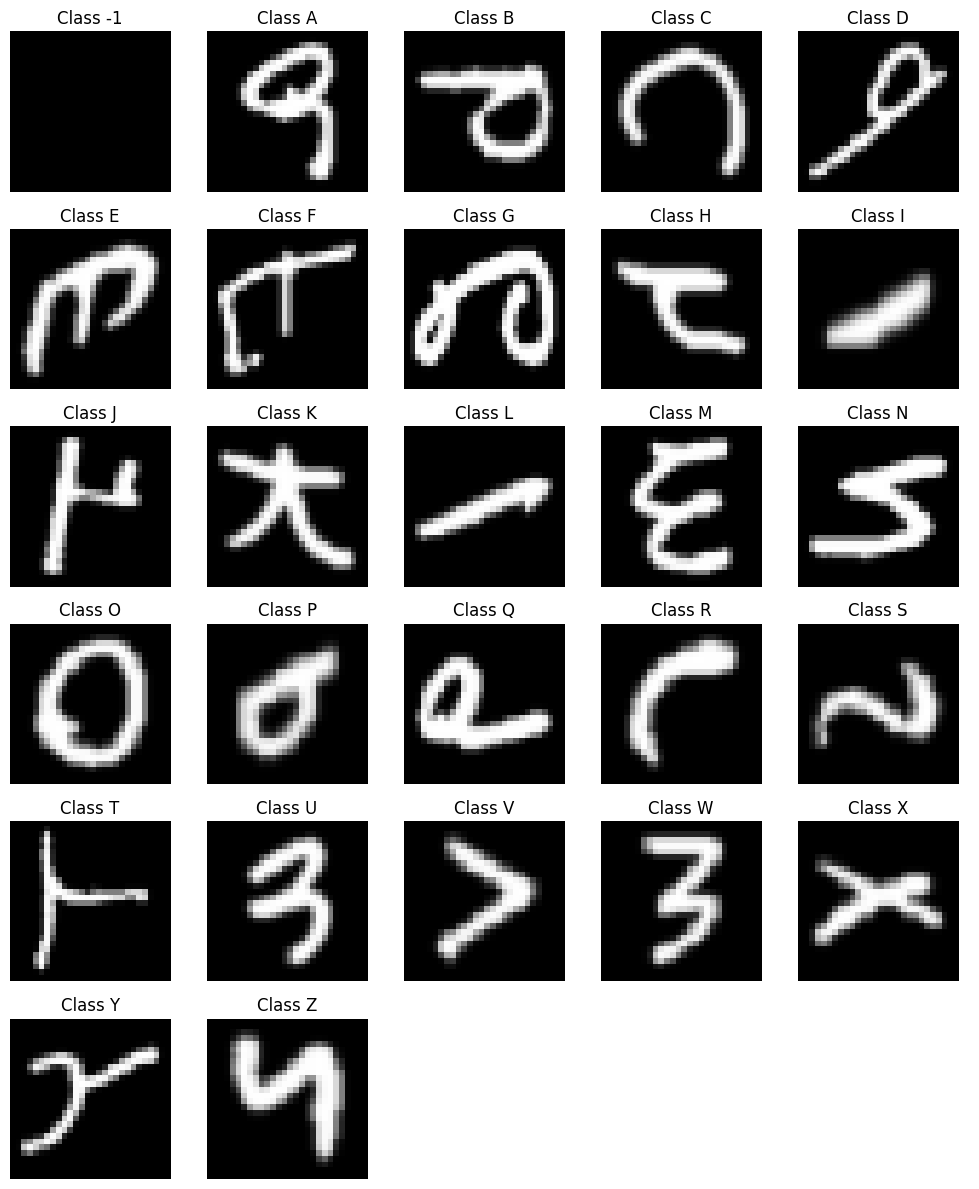

In [10]:
plot_random_images_per_class_from_dataframe(df_eda, image_size=28, num_images_per_row=5)

#### Results

Looks like the images are representing their labels correctly, but they are not oriented in an upright position. In addition, the '-1' class contains images of solid colors

## Number of Images in Each Class <a id = '3.5'></a>

In [11]:
def count_images_per_class(data):
    # Extract classes from the first column
    classes = data.iloc[:, 0]

    # Get unique classes and count occurrences
    unique_classes, counts = np.unique(classes, return_counts=True)

    # Create a dictionary to store class counts
    class_counts = dict(zip(unique_classes, counts))

    return class_counts

In [12]:
def plot_class_distribution(data):
    classes = data.iloc[:, 0]

    # Check if the classes are numerical and need mapping
    if classes.apply(lambda x: isinstance(x, int)).all():
        # Map numerical labels to alphabet labels
        mapped_classes = classes.apply(map_labels)
    else:
        mapped_classes = classes

    # Get unique classes and count occurrences
    unique_classes, counts = np.unique(mapped_classes, return_counts=True)

    # Plotting the graph
    plt.figure(figsize=(10, 6))
    plt.bar(unique_classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.xticks(unique_classes)
    plt.show()

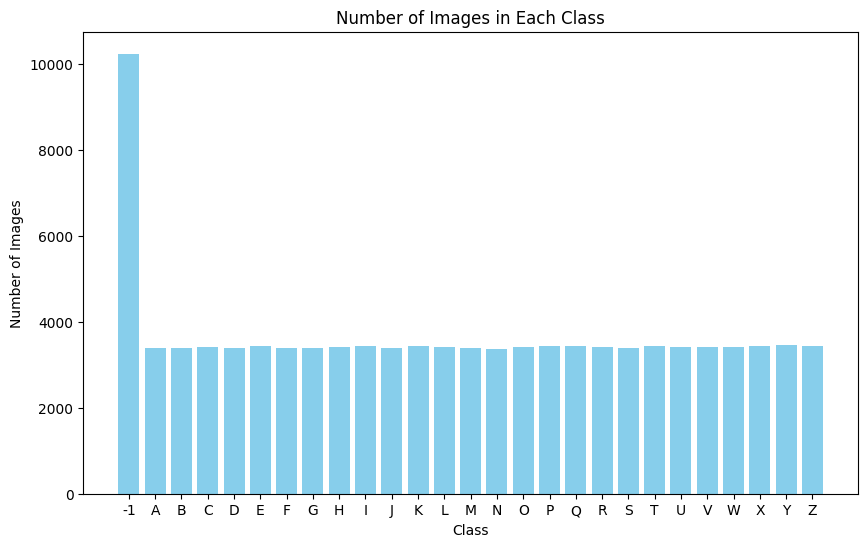

In [13]:
plot_class_distribution(df_eda)

#### Results

There are approximately 10,000 images in the '-1' class, whereas the other classes each have around 3,700 images.

## Pixel Variability in Each Class <a id = '3.6'></a>

__What is pixel variability__

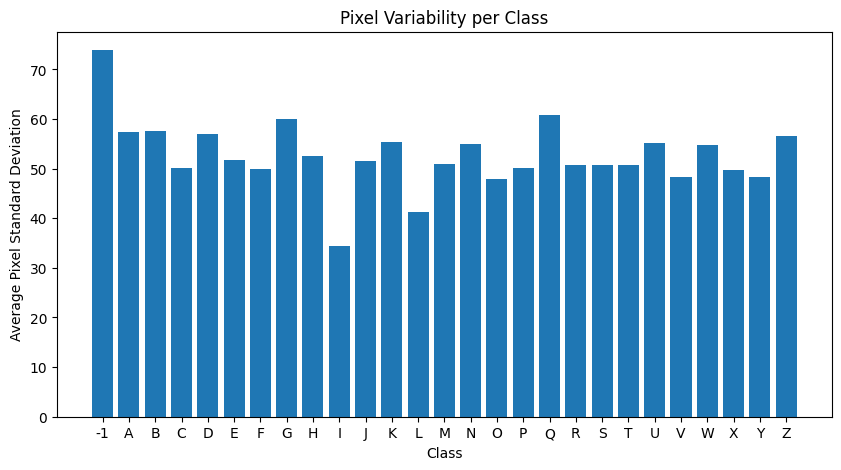

In [14]:
# Extract labels and pixel data
labels = df_eda.iloc[:, 0]  # Assuming the first column contains labels
pixel_data = df_eda.iloc[:, 1:]  # Assuming pixel data starts from the second column

# Get unique classes and sort them alphabetically
unique_classes = sorted(labels.unique())

# Initialize a dictionary to store standard deviation for each class
std_per_class = {}

# Calculate standard deviation for each class
for cls in unique_classes:
    class_indices = labels[labels == cls].index
    class_pixel_data = pixel_data.loc[class_indices]
    std_per_class[cls] = class_pixel_data.values.std(axis=0).mean()

# Plotting the pixel variability
plt.figure(figsize=(10, 5))
plt.bar(std_per_class.keys(), std_per_class.values())
plt.xlabel('Class')
plt.ylabel('Average Pixel Standard Deviation')
plt.title('Pixel Variability per Class')
plt.show()

# Data Cleaning <a id = '4'></a>

## Excluding Images with Constant Pixel Values <a id = '4.1'></a>

Number of images after removing blank images: 88800


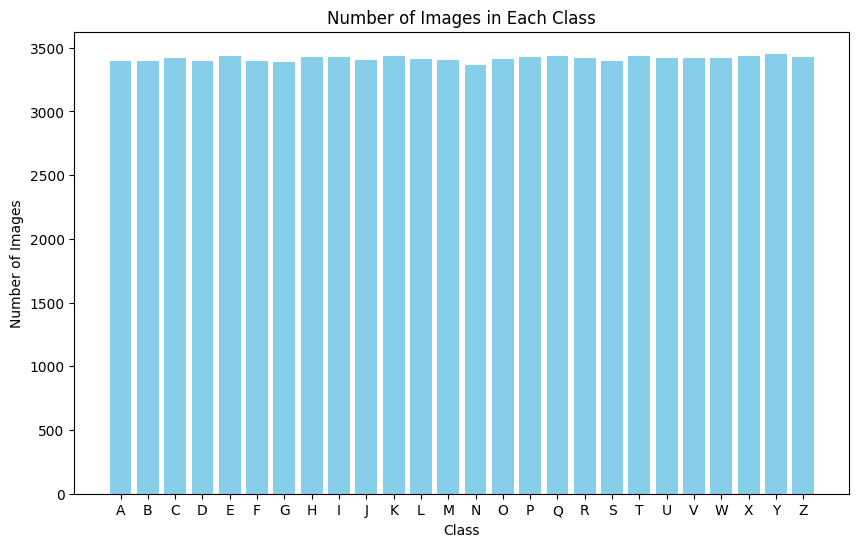

In [15]:
# Duplicate DF
cleaned_df = df.copy()

# Filtering
cleaned_df = cleaned_df[cleaned_df.iloc[:, 0] != -1]

# Print the number of images after removing blank images
print(f'Number of images after removing blank images: {cleaned_df.shape[0]}')
plot_class_distribution(cleaned_df)

# Data Preprocessing <a id = '5'></a>

## Flipping the Images Upright <a id = '5.1'></a>

We have realised that the images are flipped vertically and are roateted 90 degree anti clockwise

In [16]:
# Define a function to reshape and process images
def process_image(row):
    label = row[0] 
    pixels = np.array(row[1:], dtype=np.uint8) 
    image = pixels.reshape(28, 28)  # Reshape to original image dimensions (assuming 28x28)
    return label, image

# Flip vertically and rotate 90 degrees using cv2
def flip_and_rotate(image):
    # Flip vertically
    flipped_image = cv2.flip(image, 0)
    # Rotate 90 degrees clockwise
    rotated_image = cv2.rotate(flipped_image, cv2.ROTATE_90_CLOCKWISE)
    return rotated_image.flatten()

# Process each row in the dataframe
processed_images = []
for index, row in cleaned_df.iterrows():
    label, image = process_image(row)
    processed_image = flip_and_rotate(image)
    processed_images.append((label, processed_image))

# Convert processed images back to dataframe if needed
upright_image_df = pd.DataFrame(processed_images, columns=['Label', 'Processed_Image'])

# Convert the pixels to columns
upright_image_df_pixels = upright_image_df['Processed_Image'].apply(pd.Series)

# Rename columns
upright_image_df_pixels.columns = [f'{i+1}' for i in range(len(upright_image_df_pixels.columns))]

# Concatenate Label column with the new pixel columns
upright_image_df = pd.concat([upright_image_df['Label'], upright_image_df_pixels], axis=1)

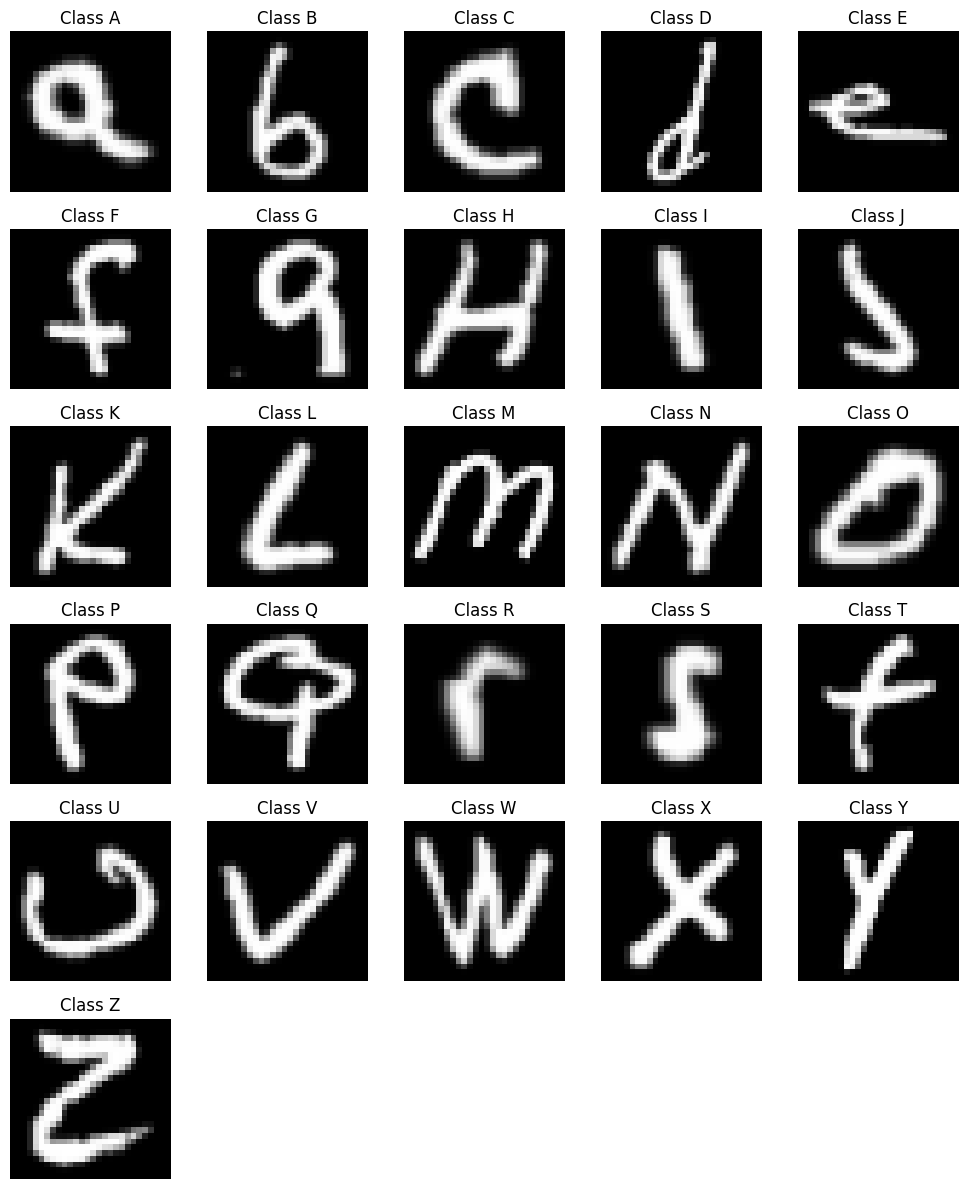

In [17]:
plot_random_images_per_class_from_dataframe(upright_image_df, image_size=28, num_images_per_row=5)

## Normalizing the Images <a id = '5.2'></a>

In [18]:
# Convert DataFrame to NumPy array
data = upright_image_df.values

# Assuming each image is 28x28 pixels and the remaining columns are pixel values
image_size = 28
num_images = data.shape[0]

# Extract labels and pixel data
labels = data[:, 0]
pixel_data = data[:, 1:]

# Extract pixel data and reshape each row into a 28x28 array
original_images = data[:, 1:].reshape(num_images, image_size, image_size).astype(np.uint8)

# Normalize pixel values
normalized_images = original_images / 255.0

# Flatten the normalized images back to rows
flattened_normalized_images = normalized_images.reshape(num_images, -1)

# Combine labels and flattened normalized images
combined_data = np.column_stack((labels, flattened_normalized_images))

# Create a new dataframe with the combined data
normalized_df = pd.DataFrame(combined_data, columns=cleaned_df.columns)

# Display the first few rows of the new dataframe
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88795,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88796,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88797,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88798,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Augmentation <a id = '5.3'></a>

In [19]:
count_per_class = count_images_per_class(normalized_df)
count_per_class

{1.0: 3396,
 2.0: 3396,
 3.0: 3419,
 4.0: 3398,
 5.0: 3437,
 6.0: 3394,
 7.0: 3385,
 8.0: 3424,
 9.0: 3428,
 10.0: 3402,
 11.0: 3438,
 12.0: 3415,
 13.0: 3402,
 14.0: 3365,
 15.0: 3408,
 16.0: 3430,
 17.0: 3435,
 18.0: 3419,
 19.0: 3392,
 20.0: 3436,
 21.0: 3419,
 22.0: 3422,
 23.0: 3423,
 24.0: 3437,
 25.0: 3453,
 26.0: 3427}

### Image needed for each class

In [20]:
target_per_class = 3500
no_images_needed_per_class = {}
print('Image needed for each class')
for key, value in count_per_class.items():
    no_images_needed_per_class[key] = target_per_class - value
no_images_needed_per_class

Image needed for each class


{1.0: 104,
 2.0: 104,
 3.0: 81,
 4.0: 102,
 5.0: 63,
 6.0: 106,
 7.0: 115,
 8.0: 76,
 9.0: 72,
 10.0: 98,
 11.0: 62,
 12.0: 85,
 13.0: 98,
 14.0: 135,
 15.0: 92,
 16.0: 70,
 17.0: 65,
 18.0: 81,
 19.0: 108,
 20.0: 64,
 21.0: 81,
 22.0: 78,
 23.0: 77,
 24.0: 63,
 25.0: 47,
 26.0: 73}

### Resample data

In [21]:
resampled_df_data = []
for class_label, target_count in no_images_needed_per_class.items():
    class_data = normalized_df[normalized_df[0] == class_label]
    # Resample the images
    resampled_df_data.append(resample(class_data, n_samples = target_count, random_state=42))

resampled_df = pd.concat(resampled_df_data)
resampled_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
82575,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29379,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28419,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39088,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66412,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20396,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Extract the labels and images
labels = resampled_df.iloc[:, 0].values
images = resampled_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)

# Define the ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

# Augment the entire dataset
augmented_images = []
augmented_labels = []

for image, label in zip(images, labels):
    image = image.reshape(1, 28, 28, 1)  # Reshape to (1, 28, 28, 1) for the generator
    aug_iter = datagen.flow(image, batch_size=1)
    aug_image = next(aug_iter)[0].astype(np.float32)  # Normalize the image
    augmented_images.append(aug_image)
    augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


# Flatten images back to the original format and create a new DataFrame
flattened_images = augmented_images.reshape(-1, 28*28)
augmented_df = pd.DataFrame(flattened_images)
augmented_df.insert(0, 'label', augmented_labels)

augmented_df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sample of the augmented dataframe

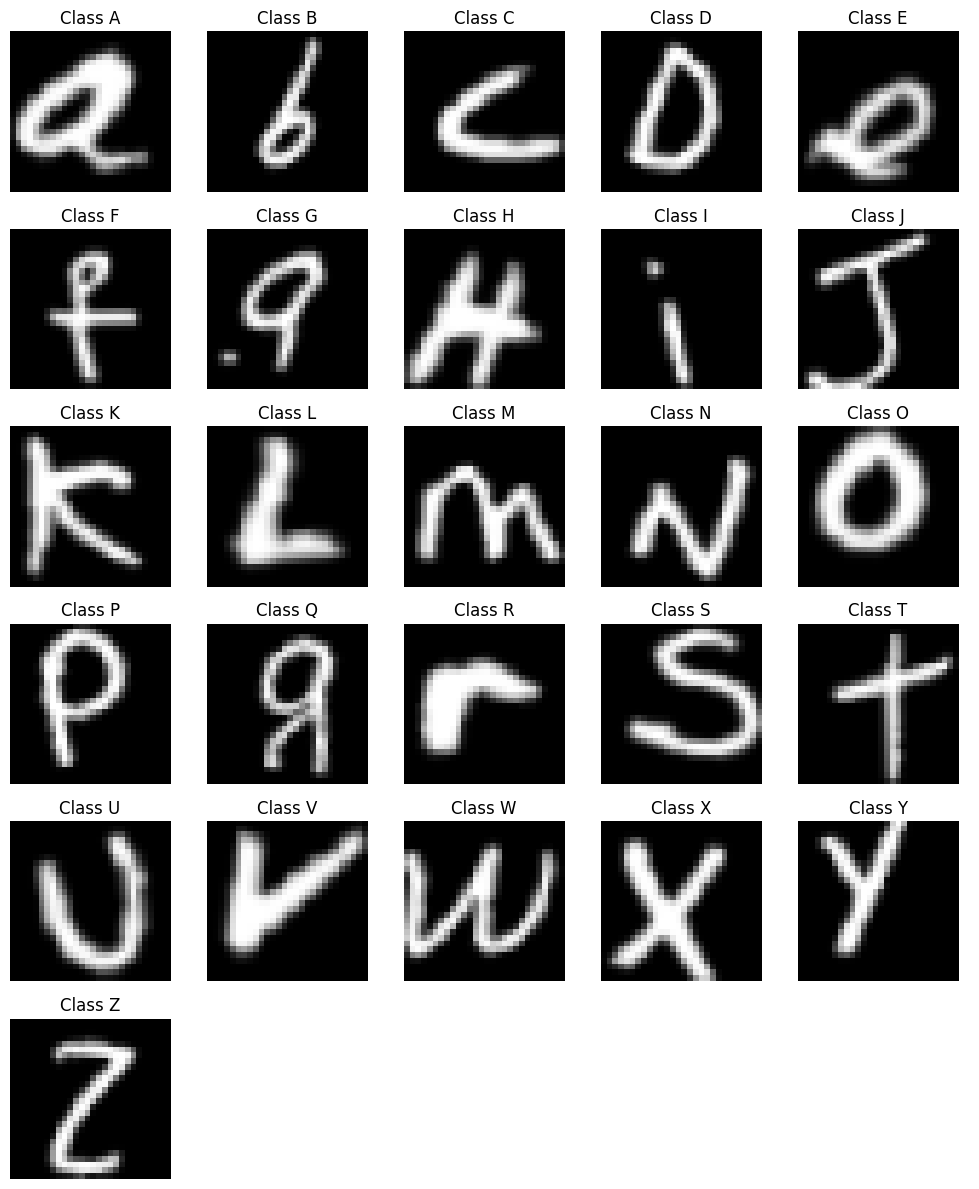

In [23]:
plot_random_images_per_class_from_dataframe(augmented_df, image_size=28, num_images_per_row=5)

### Add the augmented images back to the dataframe

In [24]:
# Create a dictionary to rename columns from their current names to 0 to 784
column_names = {old_name: new_name for old_name, new_name in zip(augmented_df.columns, range(len(augmented_df.columns)))}

# Rename the columns of augmented_df
augmented_df.rename(columns=column_names, inplace=True)
augmented_df

# Concatenate the dataframes (Normalized DF and Augmented DF)
preprocessed_df = pd.concat([normalized_df, augmented_df], axis=0, ignore_index=True)
preprocessed_df[0] = preprocessed_df[0].astype(int)
# Display the first few rows of the combined dataframe
preprocessed_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90995,26,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90996,26,0.0,0.0,0.0,0.006328,0.059340,0.054346,0.106576,0.240545,0.291744,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90997,26,0.0,0.0,0.0,0.000000,0.000855,0.001874,0.000762,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90998,26,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007646,0.004948,0.002249,0.0,0.0,0.0,0.0,0.0,0.0,0.0


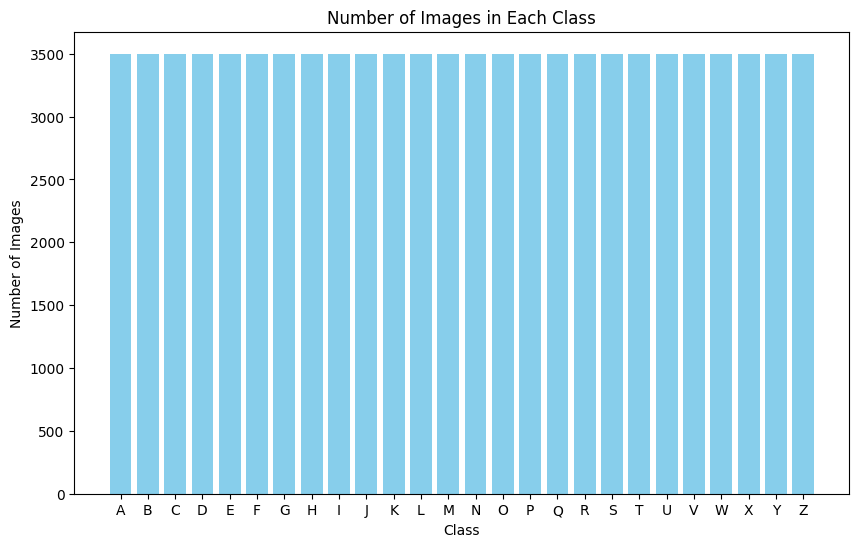

In [25]:
plot_class_distribution(preprocessed_df)

# Deep Convolutional GAN (DCGAN) <a id = '6'></a>

## Base Model (Have not run)

In [27]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        # Loss function
        self.d_losses = []
        self.g_losses = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [28]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

KeyboardInterrupt: 

At 100 epochs:

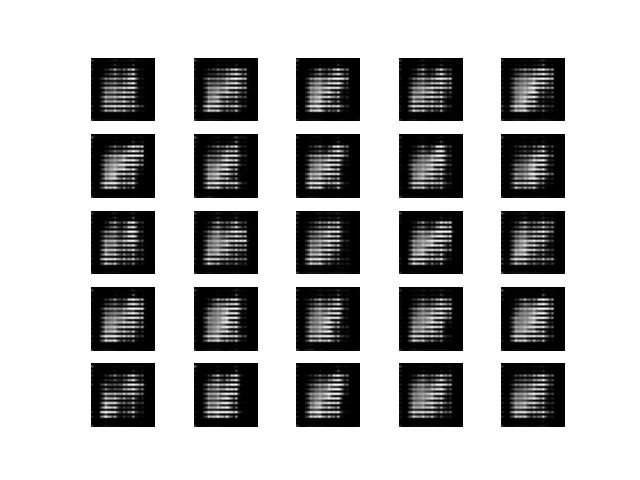

At 9800 epochs:

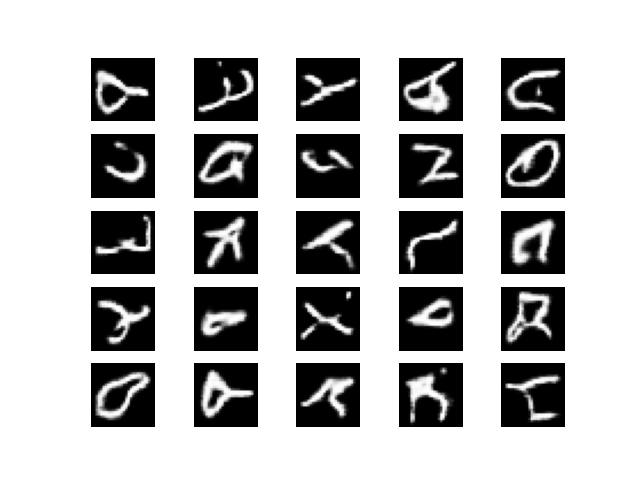

## Adding more layers to the discrimator

In [25]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        # Add one more Conv2D layer
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))  # New layer
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
        
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        # Loss function
        self.d_losses = []
        self.g_losses = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_19 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_20 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 4, 256)       

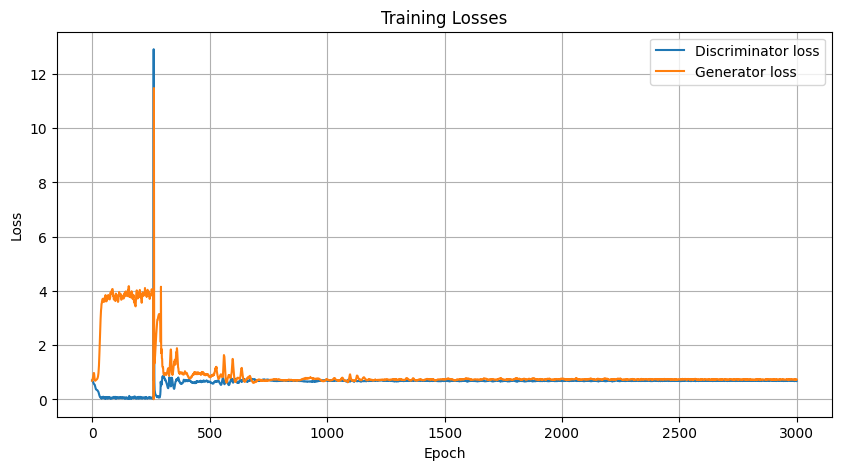

In [35]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)


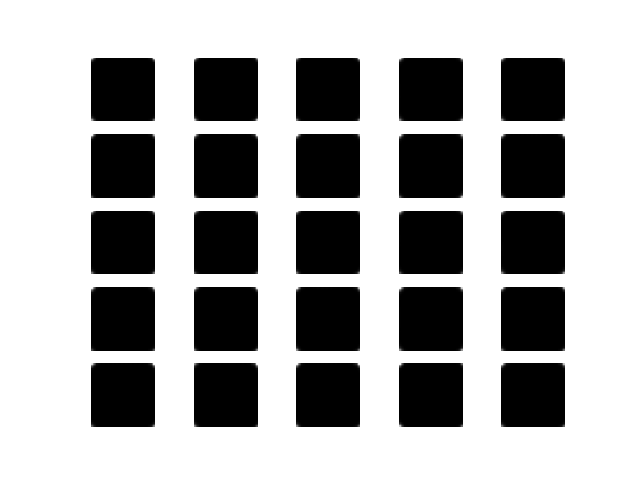


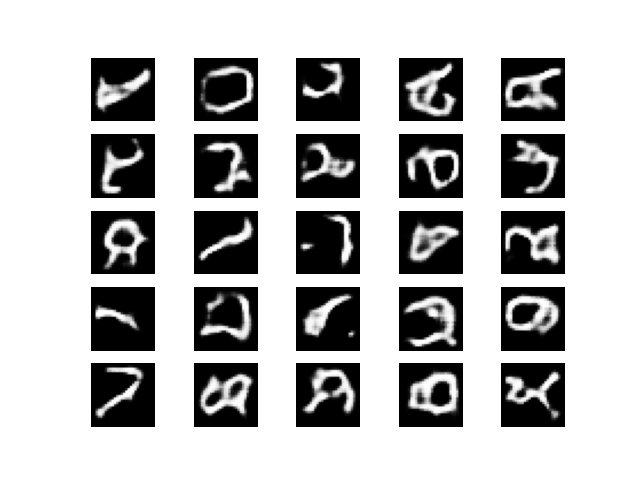

## Change dense unit to 2000 (Best rn)

In [31]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(2000 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 2000)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        # Add one more Conv2D layer
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))  # New layer
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
        
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
            # Loss function
        self.d_losses = []
        self.g_losses = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 256)       

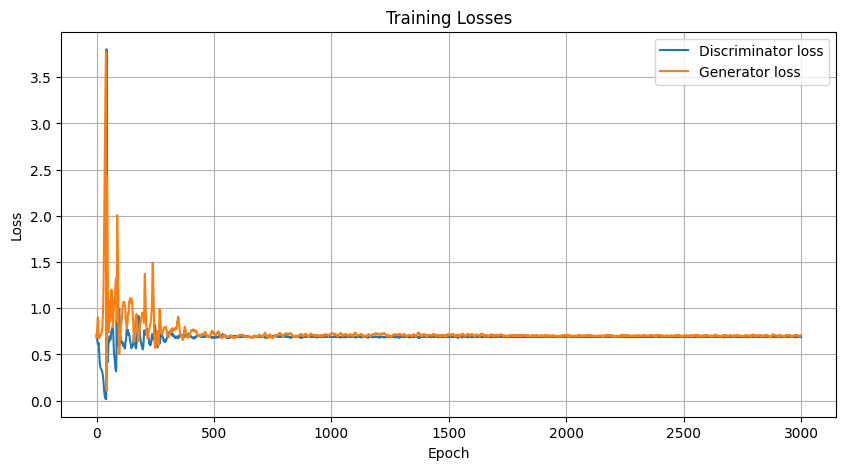

In [32]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)

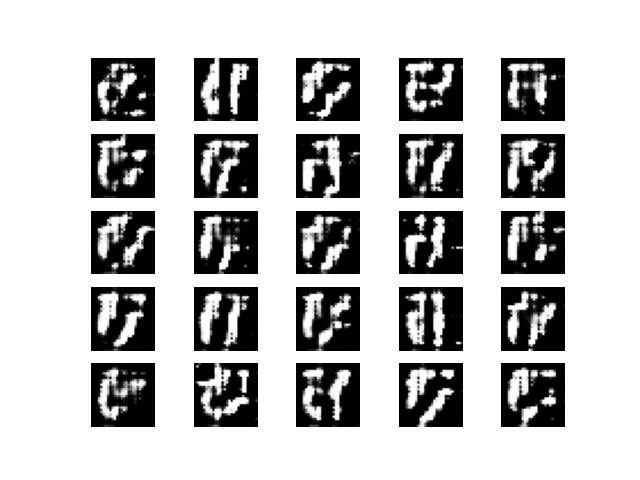


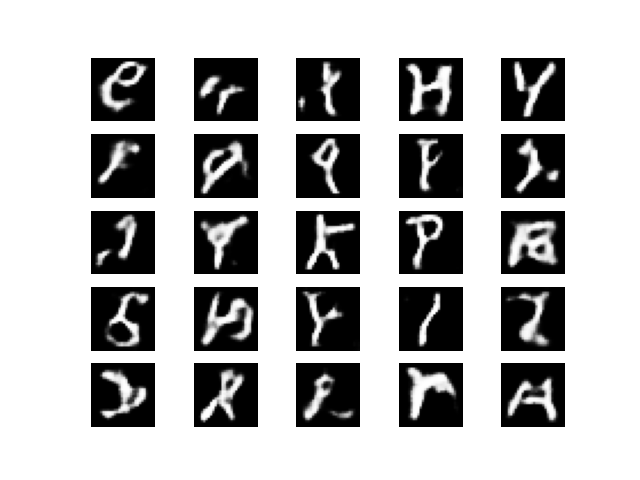

## Adding one more dense layer for the discrimator (Have not run)

In [ ]:
from tensorflow.keras.layers import Activation
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(2000 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 2000)))
        
        # Upsample to 14x14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())  # Add batch normalization
        
        # Upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())  # Add batch normalization
        
        # Final output layer
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
    
        return Model(noise, img)
    
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))  # New layer
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        
        # Add one more dense layer
        model.add(Dense(256))  # Adjust the units as per your architecture needs
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
        
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_accuracy)), self.d_accuracy, label="Discriminator Accuracy")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        # Loss function
        self.d_losses = []
        self.g_losses = []
        # Accuracy
        self.d_accuracy = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            # Store accuracy
            self.d_accuracy.append(100 * d_loss[1])
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()
        self.plot_accuracy()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [ ]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)

## Adding one more dense layer for the discrimator and using generator From github (Try base and 1000,  2000)

code from https://github.com/nicknochnack/GANBasics/blob/main/FashionGAN-Tutorial.ipynb

In [34]:
from tensorflow.keras.layers import Activation
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential()

        model.add(Dense(1500 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 1500)))
        
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))  # New layer
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        
        # Add one more dense layer
        model.add(Dense(256))  # Adjust the units as per your architecture needs
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
        
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_accuracy)), self.d_accuracy, label="Discriminator Accuracy")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        # Loss function
        self.d_losses = []
        self.g_losses = []
        # Accuracy
        self.d_accuracy = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            # Store accuracy
            self.d_accuracy.append(100 * d_loss[1])
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()
        self.plot_accuracy()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [35]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 256)       

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_11/model_10/sequential_1/conv2d_16/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\asyncio\windows_events.py", line 316, in run_forever
      super().run_forever()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\genes\AppData\Local\Temp\ipykernel_34392\2539790920.py", line 2, in <module>
      dcgan.train(epochs=3000, batch_size=256, save_interval=50)
    File "C:\Users\genes\AppData\Local\Temp\ipykernel_34392\2034303922.py", line 145, in train
      g_loss = self.combined.train_on_batch(noise, valid)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 2381, in train_on_batch
      logs = self.train_function(iterator)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\genes\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_11/model_10/sequential_1/conv2d_16/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[256,14,14,2000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_11/model_10/sequential_1/conv2d_16/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1043875]

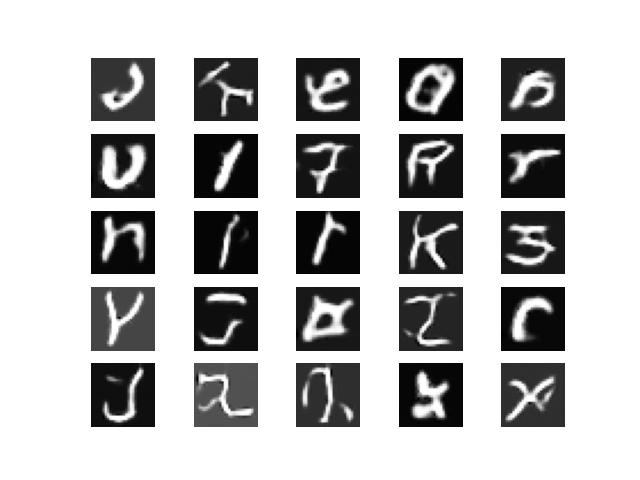

## Make generator more complex

Add a upsamplling layer

In [26]:
from tensorflow.keras.layers import Activation
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential()

        model.add(Dense(1500 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 1500)))

        # Upsampling layers
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))  # New layer
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        
        # Add one more dense layer
        model.add(Dense(256))  # Adjust the units as per your architecture needs
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
        
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_accuracy)), self.d_accuracy, label="Discriminator Accuracy")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        # Loss function
        self.d_losses = []
        self.g_losses = []
        # Accuracy
        self.d_accuracy = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            # Store accuracy
            self.d_accuracy.append(100 * d_loss[1])
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()
        self.plot_accuracy()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)       

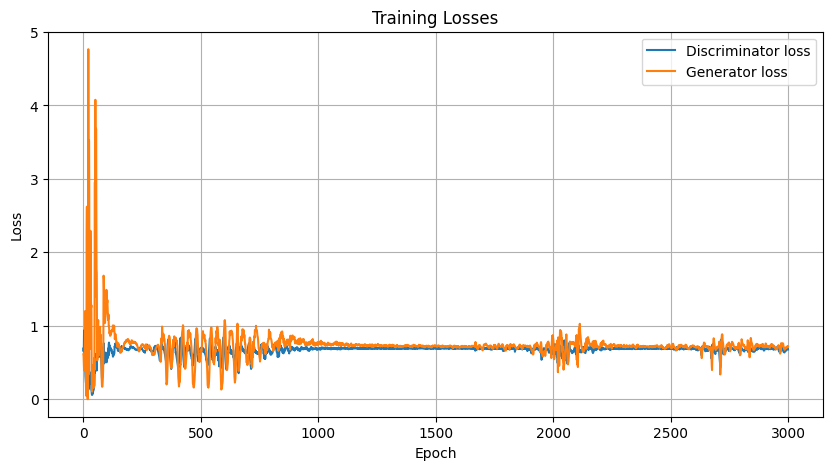

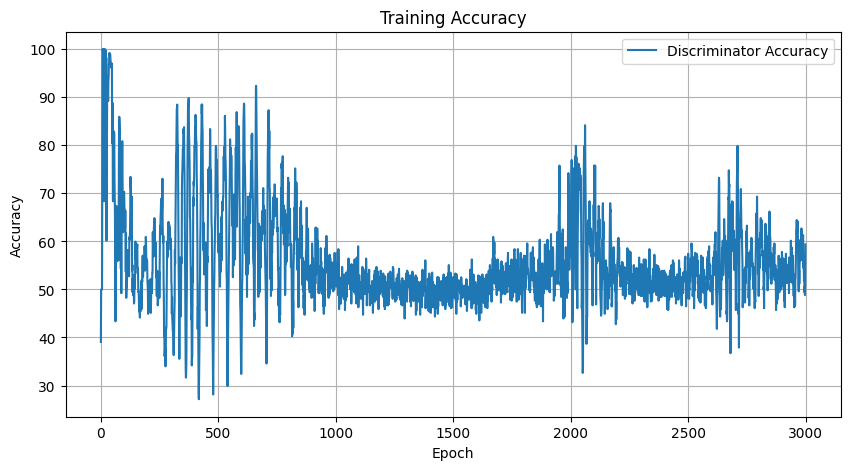

In [27]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)

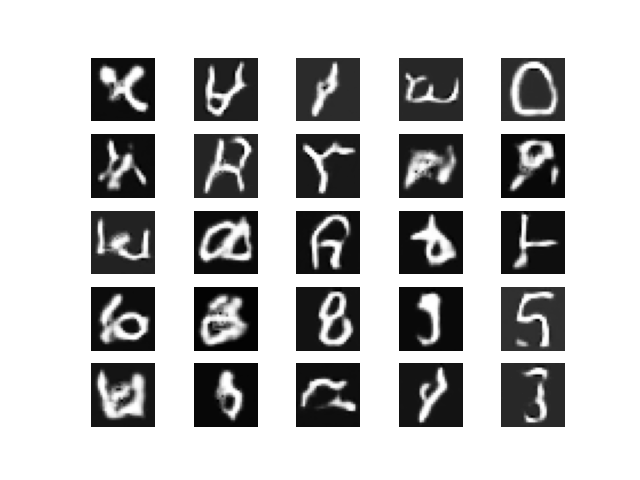

## TRY (Fuly from github) (Have not run too)

In [ ]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential()

        model.add(Dense(1000 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 1000)))
        model.add(UpSampling2D())
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
        
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_accuracy)), self.d_accuracy, label="Discriminator Accuracy")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
        # Loss function
        self.d_losses = []
        self.g_losses = []
        # Accuracy
        self.d_accuracy = []
        
    def train(self, epochs, batch_size=128, save_interval=50):
        # Assuming your data is in a pandas DataFrame `df`
        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values  # assuming first column is labels, rest are pixels
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)  # reshape to image shape
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            # Store accuracy
            self.d_accuracy.append(100 * d_loss[1])
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

        # Plot losses for every epoch
        self.plot_loss()
        self.plot_accuracy()

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/DCGAN', exist_ok=True)
        fig.savefig("generated_mnist/DCGAN/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [ ]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=3000, batch_size=256, save_interval=50)

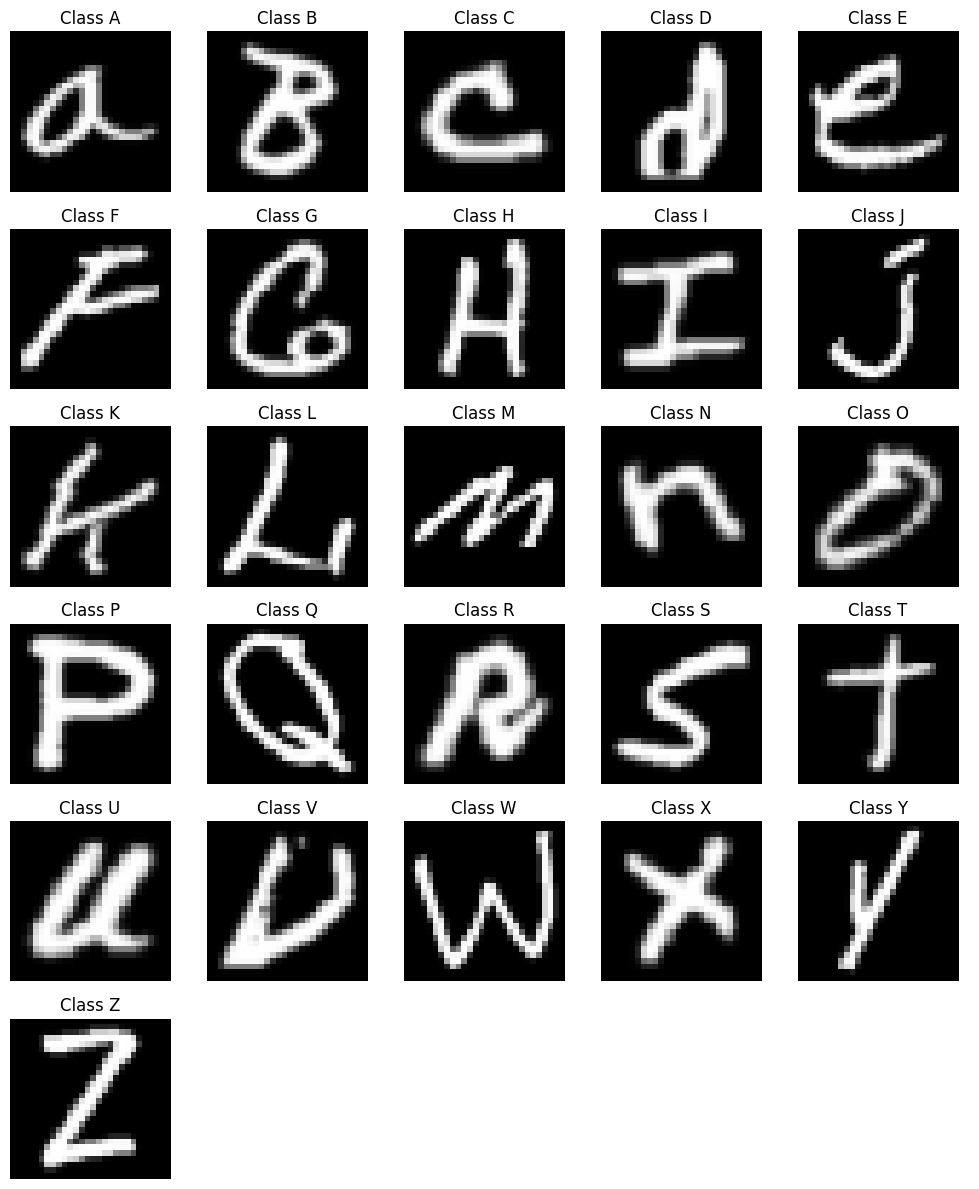

In [61]:
plot_random_images_per_class_from_dataframe(preprocessed_df, image_size=28, num_images_per_row=5)

# Conditional GAN <a id = '7'></a>

Explantion
- CGANs is a type of Generative Adversarial Network that adds additional information into both the generator and the discriminator to condition the generation process. This additional information can be any type of label or structured data such as class labels, images or other data that helps the generation process.
- It allows the generator to create more controlled and contextually appropriate outputs by using the additional information given to it.

Difference between CGANs and DCGANs
- CGANs uses additional information as conditions into the generation process while DCGANs focus on using convolutional networks for better performance in image data.
- CGANs are used for tasks that need controlled generated based on the input conditions while DCGANs are used for generating high-quality, realistic images.
- CGANs defining feature is the conditioning mechanism while DCGANs specifically use deep convolutional networks for both the generator and discriminator, emphasizing the architecture rather than conditioning.

Reference: https://medium.com/analytics-vidhya/dcgan-cgan-and-sagan-the-cifar-10-dataset-206cbb851327

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Dropout, Input, Embedding, multiply, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os

class CGAN():
    
    def __init__(self, rows, cols, channels, num_classes, latent_dim=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels  # Updated to handle grayscale (1 channel)
        self.num_classes = num_classes
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise and the label as input and generates images
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator([img, label])
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Loss function
        self.d_losses = []
        self.g_losses = []

        # Initialize variables for tracking best MSE
        self.best_mse = float('inf')  # Initialize with a very large number
        self.best_generated_imgs = None
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = Concatenate()([noise, label_embedding])
        
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim + self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))  # Output single-channel (grayscale)
        model.summary()
        
        img = model(model_input)
        return Model([noise, label], img)
    
    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        label_embedding = Reshape(self.img_shape)(label_embedding)
        
        model_input = multiply([img, label_embedding])
        
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        validity = model(model_input)
        return Model([img, label], validity)

    def compute_mse(self, real_images, generated_images):
        # Sample the same number of images from generated_images as from real_images
        num_images = real_images.shape[0]
        gen_images_sampled = generated_images[np.random.randint(0, generated_images.shape[0], num_images)]
        
        # Compute MSE
        mse = np.mean((real_images - gen_images_sampled) ** 2)
        return mse

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def train(self, epochs, batch_size=128, save_interval=50):

        # Extract image data and convert to numpy array
        X_train = preprocessed_df.iloc[:, 1:].values
        y_train = preprocessed_df.iloc[:, 0].values
        X_train = X_train.astype(np.float32) / 255.0
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_labels = np.random.randint(0, self.num_classes, batch_size)
            gen_imgs = self.generator.predict([noise, gen_labels])
            
            # Train the discriminator (classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            valid_labels = np.random.randint(0, self.num_classes, batch_size)
            
            # Train the generator (generator wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch([noise, valid_labels], valid)
    
            # Store losses
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            # Print progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                # Calculate MSE score
                real_images = X_train[np.random.randint(0, X_train.shape[0], 100)]
                mse_score = self.compute_mse(real_images, gen_imgs)
                print(f"MSE score at epoch {epoch}: {mse_score}")
                
                # Update best MSE and save corresponding generated images
                if mse_score < self.best_mse:
                    self.best_mse = mse_score
                    self.best_generated_imgs = gen_imgs.copy()
            
        # Plot losses for every epoch
        self.plot_loss()
            
        # Print best MSE score found during training
        print(f"Best MSE score: {self.best_mse}")
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.random.randint(0, self.num_classes, r * c).reshape(-1, 1)
    
        gen_imgs = self.generator.predict([noise, sampled_labels])
    
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')  # Display grayscale images
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/CGAN', exist_ok=True)
        fig.savefig("generated_mnist/CGAN/cgan_mnist_{:d}.png".format(epoch))
        plt.close()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_7 (Flatten)         (None, 6272)            

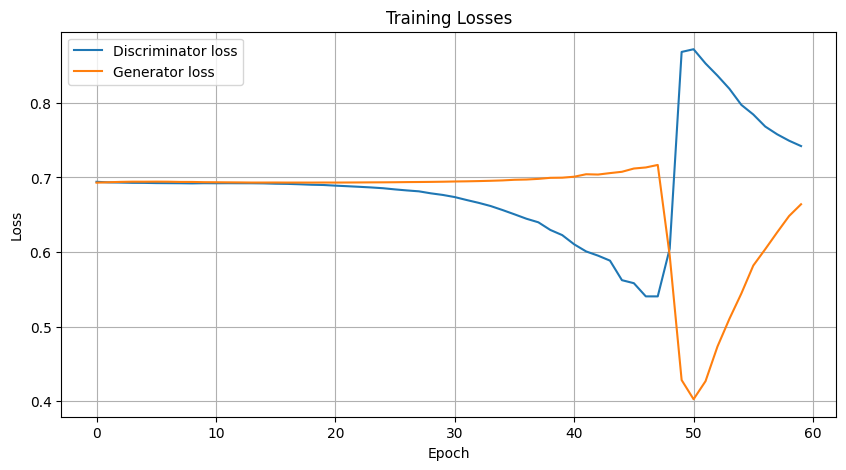

Best MSE score: 0.21355341374874115


In [34]:
# Example usage:
# Assuming `preprocessed_df` is the preprocessed DataFrame with labels in the first column
num_classes = preprocessed_df.iloc[:, 0].nunique()
cgan = CGAN(rows=28, cols=28, channels=1, num_classes=num_classes)
cgan.train(epochs=60, batch_size=256, save_interval=50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Dropout, Input, Embedding, multiply, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

class CGAN():

    def __init__(self, rows, cols, channels, num_classes, latent_dim=100):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels  # Updated to handle grayscale (1 channel)
        self.num_classes = num_classes
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise and the label as input and generates images
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator([img, label])
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Loss function
        self.d_losses = []
        self.g_losses = []
        self.js_divergences = []  # Track JS divergences

        # Initialize variables for tracking best MSE
        self.best_mse = float('inf')  # Initialize with a very large number
        self.best_generated_imgs = None
        self.best_js_div = float('inf')  # Initialize best JS divergence
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = Concatenate()([noise, label_embedding])
        
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim + self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))  # Output single-channel (grayscale)
        model.summary()
        
        img = model(model_input)
        return Model([noise, label], img)
    
    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        label_embedding = Reshape(self.img_shape)(label_embedding)
        
        model_input = multiply([img, label_embedding])
        
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        validity = model(model_input)
        return Model([img, label], validity)

    def compute_mse(self, real_images, generated_images):
        # Sample the same number of images from generated_images as from real_images
        num_images = real_images.shape[0]
        gen_images_sampled = generated_images[np.random.randint(0, generated_images.shape[0], num_images)]
        
        # Compute MSE
        mse = np.mean((real_images - gen_images_sampled) ** 2)
        return mse

    # def compute_kl_divergence(self, real_data, generated_data):
    #     kl_divergences = []
    #     for i in range(real_data.shape[-1]):
    #         kl_div = scipy.stats.entropy(real_data[:, i], generated_data[:, i])
    #         kl_divergences.append(kl_div)
    #     return kl_divergences

    def compute_js_divergence(self, real_data, generated_data):
        js_divergences = []
        for i in range(real_data.shape[-1]):
            p = real_data[:, i]
            q = generated_data[:, i]
            m = 0.5 * (p + q)
            js_div = 0.5 * (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m))
            js_divergences.append(js_div)
        return js_divergencesjs_divs.append(scipy.stats.entropy(p, m))


    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.d_losses)), self.d_losses, label="Discriminator loss")
        plt.plot(range(len(self.g_losses)), self.g_losses, label="Generator loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def train(self, epochs, batch_size=128, save_interval=50):

        # Assuming preprocessed_df is your DataFrame with images
        X_train = preprocessed_df.iloc[:, 1:].values
        y_train = preprocessed_df.iloc[:, 0].values
        X_train = X_train.astype(np.float32) / 255.0
        X_train = X_train.reshape(-1, self.img_rows, self.img_cols, self.channels)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_labels = np.random.randint(0, self.num_classes, batch_size)
            gen_imgs = self.generator.predict([noise, gen_labels])
            
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            # Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            valid_labels = np.random.randint(0, self.num_classes, batch_size)
            
            g_loss = self.combined.train_on_batch([noise, valid_labels], valid)
    
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                real_images = X_train[np.random.randint(0, X_train.shape[0], 100)]
                mse_score = self.compute_mse(real_images, gen_imgs)
                                                                      # kl_divs = self.compute_kl_divergence(real_images.flatten(), gen_imgs.flatten())
                js_divs = self.compute_js_divergence(real_images.flatten(), gen_imgs.flatten())
                
                print(f"MSE score at epoch {epoch}: {mse_score}")
                                                                              # print(f"KL Divergence at epoch {epoch}: {kl_divs}")
                print(f"JS Divergence at epoch {epoch}: {js_divs}")

                # Update best MSE score
                if mse_score < self.best_mse:
                    self.best_mse = mse_score
                    self.best_generated_imgs = gen_imgs.copy()

                # Update best JS divergence
                current_js_div = np.mean(js_divs)
                if current_js_div < self.best_js_div:
                    self.best_js_div = current_js_div
                    print(f"Best JS Divergence updated to {self.best_js_div} at epoch {epoch}")
        
        self.plot_loss()
        print(f"Best MSE score: {self.best_mse}")
        print(f"Best JS Divergence: {self.best_js_div}")
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.random.randint(0, self.num_classes, r * c).reshape(-1, 1)
    
        gen_imgs = self.generator.predict([noise, sampled_labels])
    
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')  # Display grayscale images
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        os.makedirs('generated_mnist/CGAN', exist_ok=True)
        fig.savefig("generated_mnist/CGAN/cgan_mnist_{:d}.png".format(epoch))
        plt.close()


In [ ]:
# Example usage:
# Assuming `preprocessed_df` is the preprocessed DataFrame with labels in the first column
num_classes = preprocessed_df.iloc[:, 0].nunique()
cgan = CGAN(rows=28, cols=28, channels=1, num_classes=num_classes)
cgan.train(epochs=60, batch_size=256, save_interval=50)